In [1]:
%tensorflow_version 1.x
import tensorflow as tf
#tf.enable_eager_execution()
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy import optimize
import matplotlib.dates as dates
from ipywidgets import interact, widgets
from scipy.integrate import solve_ivp
plt.style.use('seaborn-poster')
matplotlib.rcParams['figure.figsize'] = (10., 6.)
import copy
import sympy
%matplotlib inline
import scipy as sp
from scipy.integrate import odeint
import datetime as dt
import timeit
import time
import os
from scipy.interpolate import CubicSpline
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
np.set_printoptions(threshold=np.inf)
from prettytable import PrettyTable  
import matplotlib as mpl

TensorFlow 1.x selected.


In [7]:
data = pd.read_csv("https://raw.githubusercontent.com/Jiel73654/Qualify-Exam_JieLong/master/Public-Dataset-Daily-Case-Info.csv",error_bad_lines = False)
data[26:]

,DATE,TOTAL_CASES,NEW_CASES,TOTAL_CONFIRMED,NEW_CONFIRMED,TOTAL_PROBABLE,NEW_PROBABLE,POS_TESTS,NEG_TESTS,TOTAL_TESTS,NEW_TESTS,NEW_DEATHS,TOTAL_DEATHS,NEW_RECOVERED,TOTAL_RECOVERED,NEW_ACTIVE,TOTAL_ACTIVE,NEW_HOSP,TOTAL_HOSP
26,3/30/2020,1834,297.0,NaN,NaN,NaN,NaN,1834.0,21470.0,23304.0,2730.0,6.0,13.0,NaN,109.0,182.0,1712.0,15.0,148.0
27,3/31/2020,2239,405.0,NaN,NaN,NaN,NaN,2239.0,25121.0,27360.0,4056.0,10.0,23.0,12.0,121.0,383.0,2095.0,27.0,175.0
28,4/1/2020,2683,444.0,NaN,NaN,NaN,NaN,2683.0,29769.0,32452.0,5092.0,1.0,24.0,16.0,137.0,427.0,2522.0,25.0,200.0
29,4/2/2020,2845,162.0,NaN,NaN,NaN,NaN,2845.0,31766.0,34611.0,2159.0,8.0,32.0,83.0,220.0,71.0,2593.0,63.0,263.0
30,4/3/2020,3067,222.0,NaN,NaN,NaN,NaN,3067.0,34772.0,37839.0,3228.0,5.0,37.0,28.0,248.0,189.0,2782.0,30.0,293.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,7/25/2020,90796,1718.0,89850.0,1678.0,946.0,40.0,104656.0,1226772.0,1331428.0,9721.0,26.0,964.0,825.0,53808.0,867.0,36024.0,76.0,4196.0
143,7/26/2020,93936,3140.0,92943.0,3093.0,993.0,47.0,110435.0,1271424.0,1381859.0,50431.0,3.0,967.0,922.0,54730.0,2215.0,38239.0,48.0,4244.0
144,7/27/2020,96489,2553.0,95433.0,2490.0,1056.0,63.0,113557.0,1296839.0,1410396.0,28537.0,11.0,978.0,2509.0,57239.0,33.0,38272.0,36.0,4280.0
145,7/28/2020,99044,2555.0,97966.0,2533.0,1078.0,22.0,116549.0,1318884.0,1435433.0,25037.0,21.0,999.0,2521.0,59760.0,13.0,38285.0,92.0,4372.0


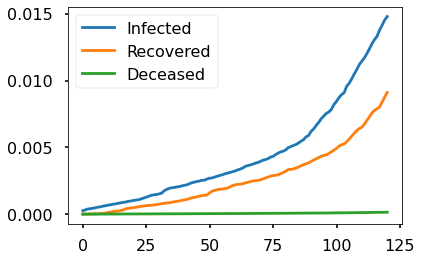

In [8]:
length = 121#time period
ic = data["TOTAL_CASES"]
IC = ic.iloc[26:].to_numpy().reshape(length,1)
dc = data["TOTAL_DEATHS"]
DC = dc.iloc[26:].to_numpy().reshape(length,1)
re = data["TOTAL_RECOVERED"]
RC = re.iloc[26:].to_numpy().reshape(length,1)
N0 = 6.82*1.e6#The total population of tennessee
T = np.arange(0,length).reshape(length,1)
II = IC - RC - DC
SS = N0 - II - RC - DC
RR = DC + RC
plt.plot(T,IC/N0)
plt.plot(T,RC/N0)
plt.plot(T,DC/N0)
plt.legend(("Infected","Recovered","Deceased"))

In [9]:
np.random.seed(12345)
tf.set_random_seed(12345)
#tf.compat.v1.disable_eager_execution()
class SIR:
    def __init__(self, I, R, S, T,N0, layers):
        self.t = T
        self.I = I
        self.R = R
        self.S = S
        self.layers = layers
        self.N = N0
        self.lb = T.min()
        self.ub = T.max()
        # Initialize NN
        self.weights1, self.biases1 = self.initialize_NN(self.layers)
        self.weights2, self.biases2 = self.initialize_NN(self.layers)
        self.weights3, self.biases3 = self.initialize_NN(self.layers)
        self.weights4, self.biases4 = self.initialize_NN(self.layers)
        self.weights5, self.biases5 = self.initialize_NN(self.layers)
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        self.I_tf = tf.placeholder(tf.float32, shape=[None, self.I.shape[1]])
        self.R_tf = tf.placeholder(tf.float32, shape=[None, self.R.shape[1]])
        self.S_tf = tf.placeholder(tf.float32, shape=[None, self.S.shape[1]])
        self.S_pred, self.I_pred, self.R_pred,self.beta_pred,self.gamma_pred,self.E1_pred, self.E2_pred, self.E3_pred, self.E4_pred = self.net_NS(
            self.t_tf)
        self.GE_loss = tf.reduce_mean(tf.abs(self.E1_pred)) + tf.reduce_mean(tf.abs(self.E2_pred)) +\
                        tf.reduce_mean(tf.abs(self.E3_pred)) + tf.reduce_mean(tf.abs(self.E4_pred))
        self.S_loss = 0
        self.I_loss = 0
        self.R_loss = 0
        iter = 0
        for i in range(len(T)):
            if T[i]%1 == 0:
                self.S_loss += tf.abs(self.S_tf[iter] - self.S_pred[i])
                self.I_loss += tf.abs(self.I_tf[iter] - self.I_pred[i])
                self.R_loss += tf.abs(self.R_tf[iter] - self.R_pred[i])
                iter += 1
        self.OB_loss = (self.I_loss + self.R_loss + self.S_loss)/iter
        self.loss = self.OB_loss + self.GE_loss
        '''
        self.loss = tf.reduce_mean(tf.abs(self.I_tf - self.I_pred)) + tf.reduce_mean(tf.abs(self.R_pred - self.R_tf)) +\
                    tf.reduce_mean(tf.abs(self.S_tf - self.S_pred)) +\
                    tf.reduce_mean(tf.abs(self.E1_pred))+ tf.reduce_mean(tf.abs(self.E2_pred)) +\
                    tf.reduce_mean(tf.abs(self.E3_pred)) + tf.reduce_mean(tf.abs(self.E4_pred)) 
        '''
        
        self.optimizer_Adam = tf.compat.v1.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
        # Optimizers
        '''
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})    
        '''                                                                                          
        init = tf.global_variables_initializer()
        self.sess.run(init)
         
        
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers)
        
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
    
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.nn.softplus(tf.add(tf.matmul(H, W), b))
        return Y

    def neural_net1(self, X, weights, biases):
        num_layers = len(weights) + 1
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.nn.sigmoid(tf.add(tf.matmul(H, W), b))
        return Y

    def net_NS(self, t):
        #gamma = self.gamma
        #beta = self.beta
        #print(x.shape)
        #print(y.shape)
        #output = self.neural_net(t, self.weights1, self.biases1)
        beta = self.neural_net1(t,self.weights4,self.biases4)
        gamma = self.neural_net1(t,self.weights5,self.biases5)
        NN=self.N
        S = self.neural_net1(t, self.weights1, self.biases1)
        I = self.neural_net1(t, self.weights2, self.biases2)
        R = self.neural_net1(t, self.weights3, self.biases3)
        #beta = output[:,3:4]
        #gamma = output[:,4:5]
        st = tf.gradients(S, t)[0]
        It = tf.gradients(I, t)[0]  
        Rt = tf.gradients(R, t)[0]
        
        E1 = st + beta*S*I
        E2 = It - beta*S*I + gamma*I
        E3 = Rt - gamma*I
        E4 = 1 - (S+I+R)
        return S,I,R,beta,gamma,E1,E2,E3,E4

    def callback(self, loss):
        print('Loss: %.3e' % (loss))
    def train(self, nIter): 

        tf_dict = {self.t_tf: self.t, self.I_tf: self.I,self.R_tf: self.R,self.S_tf: self.S}
                   
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 500 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                #gamma_value = self.sess.run(self.gamma)
                #beta_value = self.sess.run(self.beta)
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value,elapsed))
                start_time = time.time()
        '''
        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss],
                                loss_callback = self.callback)
        '''              
    def predict(self, t_star):
        tf_dict = {self.t_tf: t_star}
        S = self.sess.run(self.S_pred, tf_dict)
        I = self.sess.run(self.I_pred, tf_dict)
        R = self.sess.run(self.R_pred, tf_dict)
        beta = self.sess.run(self.beta_pred,tf_dict)
        gamma = self.sess.run(self.gamma_pred,tf_dict)
        #gamma = self.sess.run(self.gamma_pred,tf_dict)
        return S,I,R,beta,gamma

In [10]:
T = np.arange(0,length - 0.1,0.1)#here I used Nt with 0.1 stepsize
T = T.reshape(len(T),1)
layers = [1,64,64,64,1]
model = SIR(II/N0,RR/N0,SS/N0,T,1,layers)
model.train(100000)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

It: 0, Loss: 2.456e+00, Time: 4.77
It: 500, Loss: 8.011e-04, Time: 14.41
It: 1000, Loss: 8.174e-04, Time: 14.21
It: 1500, Loss: 7.495e-04, Time: 14.14
It: 2000, Loss: 8.902e-04, Time: 14.04
It: 2500, Loss: 8.816e-04, Time: 14.52
It: 3000, Loss: 8.577e-04, Time: 14.42
It: 3500, Loss: 8.589e-04, Time: 14.03
It: 4000, Loss: 7.830e-04, Time: 14.10
It: 4500, Loss: 8.399e-04, Time: 14.15
It: 5000, Loss: 7.393e-04, Time: 14.14
It: 5500, Loss: 7.825e-04, Time: 14.17
It: 6000, Loss: 8.324e-04, Time: 14.00
It: 6500, Loss: 8.078e-04, Time: 14.27
It: 7000, Loss: 8.959e-04, Time: 14.20
It: 7500, Loss: 6.877e-04, Time: 14.18
It: 8000, Loss: 6.182e-04, Time: 14.66
It: 8500, Loss: 8.263e-04, Time: 14.18
It: 9000, Loss: 8.375e-04, Time: 14.24
It: 9500, Loss: 6.034e-04, Time: 14.08
It: 10000, Loss: 5.930e-04, Time: 14.14
It: 10500, Loss: 1.086e-03, Time: 14.09
It: 11000, Loss: 5.857e-04, Time: 14.06
It: 11500, Lo

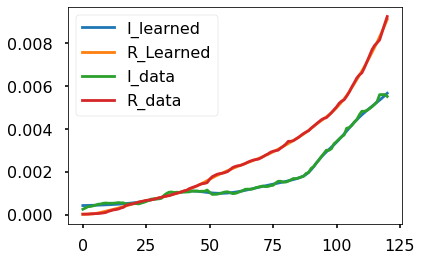

In [12]:
T = np.arange(0,121).reshape(121,1)
s,i,r,beta,gamma= model.predict(T)
plt.plot(T,i)
plt.plot(T,r)
I1 = II/N0
R1 = RR/N0
plt.plot(T,I1)
plt.plot(T,R1)
plt.legend(("I_learned","R_Learned","I_data","R_data"))

[9.99731085e-01 2.51026393e-04 1.78885630e-05]
[1.60046181]


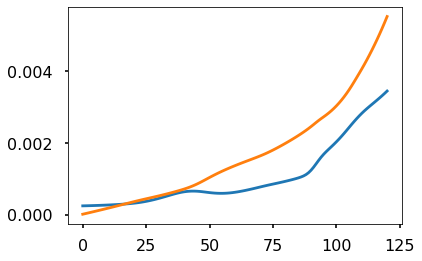

In [13]:
from scipy.integrate import odeint
# function that returns dz/dt
def sir_model(z,t,beta_value,gamma):
    s = z[0,]
    i = z[1,]
    r = z[2,]
    dsdt = -beta_value*i*s
    didt = beta_value*i*s - gamma*i
    drdt = gamma*i
    dzdt = [dsdt,didt,drdt]
    dzdt = np.array(dzdt)
    return dzdt
t = np.arange(0,T.shape[0])
# initial condition
z0 = np.array([SS[0,0]/N0,II[0,0]/N0,RR[0,0]/N0])
print(z0)
rk_s = [0.0]*T.shape[0]
rk_i = [0.0]*T.shape[0]
rk_r = [0.0]*T.shape[0]
rk_s[0] = z0[0]
rk_i[0] = z0[1]
rk_r[0] = z0[2]
# solve ODE
for l in range(1,T.shape[0]):
  # span for next time step
    tspan = [t[l-1],t[l]]
    # solve for next step
    z = odeint(sir_model,z0,tspan,args=(beta[l-1,0],gamma[l-1,0]))
    # store solution for plotting
    rk_s[l] = z[1][0]
    rk_i[l] = z[1][1]
    rk_r[l] = z[1][2]
    # next initial condition
    z0 = z[1]
plt.plot(t,rk_i)
plt.plot(t,rk_r)
#plt.plot(t,rk_s)
mul = I1[-1]/rk_i[-1]
print(mul)

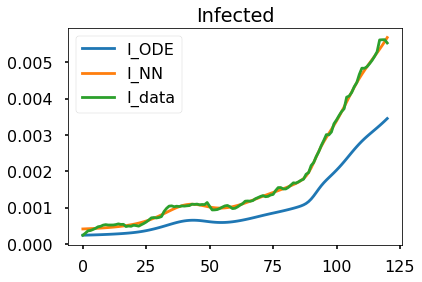

Text(0.5, 1.0, 'Relative Error')

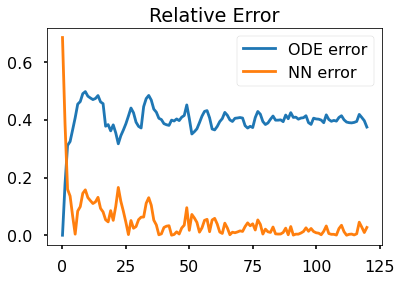

In [14]:
#here the graph is the difference between the data and RK solved
plt.plot(t,rk_i)
plt.plot(T,i)
plt.plot(T,II/N0)
plt.legend(("I_ODE","I_NN","I_data"))
plt.title("Infected")
plt.show()
#compute the error
plt.plot(np.abs(np.array(rk_i).reshape(length,1) - II/N0)/(II/N0))
plt.plot(np.abs(i - II/N0)/(II/N0))
plt.legend(("ODE error","NN error"))
plt.title("Relative Error")

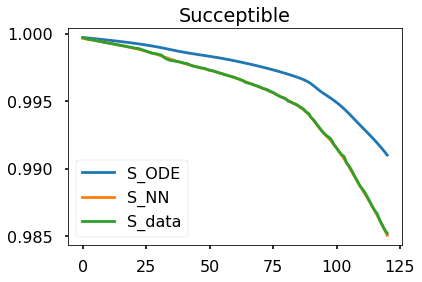

Text(0.5, 1.0, 'Relative Error')

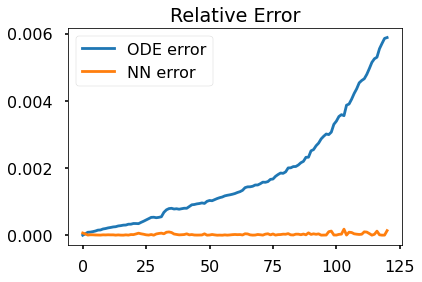

In [15]:
plt.plot(t,rk_s)
plt.plot(T,s)
plt.plot(T,SS/N0)
plt.legend(("S_ODE","S_NN","S_data"))
plt.title("Succeptible")
plt.show()
#compute the error
plt.plot(np.abs(np.array(rk_s).reshape(length,1) - SS/N0)/(SS/N0))
plt.plot(np.abs(s - SS/N0)/(SS/N0))
plt.legend(("ODE error","NN error"))
plt.title("Relative Error")

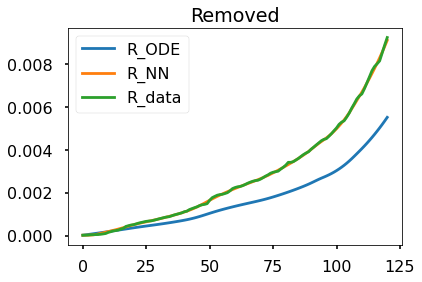

Text(0.5, 1.0, 'Relative Error')

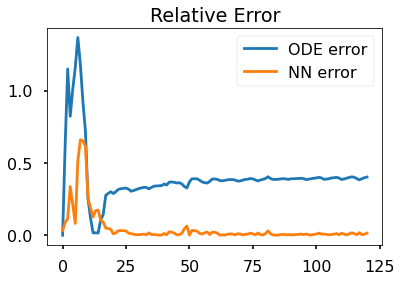

In [16]:
plt.plot(t,rk_r)
plt.plot(T,r)
plt.plot(T,RR/N0)
plt.legend(("R_ODE","R_NN","R_data"))
plt.title("Removed")
plt.show()
#compute the error
plt.plot(np.abs(np.array(rk_r).reshape(length,1) - RR/N0)/(RR/N0))
plt.plot(np.abs(r - RR/N0)/(RR/N0))
plt.legend(("ODE error","NN error"))
plt.title("Relative Error")

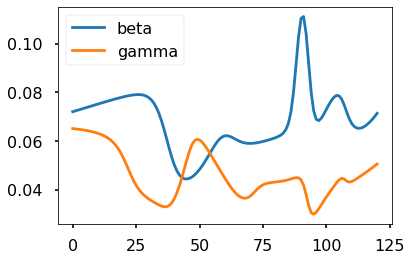

In [17]:
plt.plot(T,beta)
plt.plot(T,gamma)
plt.legend(("beta","gamma"))

Text(0.5, 1.0, 'Reproduciton Number')

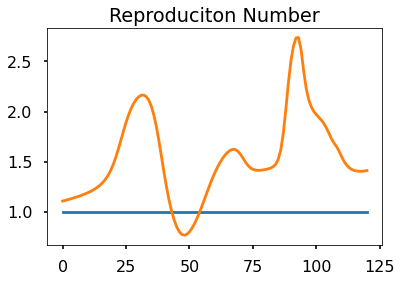

In [19]:
aa = [1]*121
plt.plot(T,aa)
plt.plot(T,beta/gamma)
plt.title("Reproduciton Number")